In [13]:
import tqdm
import torch
import torchviz
import numpy as np

from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import nn

# Операции с тензорами

Базовые операции с тензорами похожи на NumPy. 

In [6]:
x = torch.tensor(2.0, dtype=torch.float32)
y = torch.tensor([1.0, 2.0, 3.0])
x + y

tensor([3., 4., 5.])

In [7]:
id(x)

140209489579200

In [8]:
x += 2
id(x)

140209489579200

In [9]:
x = torch.ones(2, 2)
y = torch.zeros(2, 2)
x, y

(tensor([[1., 1.],
         [1., 1.]]),
 tensor([[0., 0.],
         [0., 0.]]))

In [4]:
torch.randn(2, 3)

tensor([[-1.1324, -0.5336, -0.1154],
        [ 0.5291,  2.5885,  1.3315]])

In [10]:
torch.randn(2, 3).view((-1, 1))

tensor([[ 0.1120],
        [ 0.2209],
        [ 0.8513],
        [-0.4273],
        [-0.6676],
        [-2.2599]])

Важным момент - поддержка CUDA. Существует абстракция `device` - устройство на котором будут произоводиться вычисления

In [6]:
print(torch.cuda.is_available())

cpu = torch.device('cpu')   
# cuda = torch.device('cuda')     
# cuda0 = torch.device('cuda:0')
# cuda1 = torch.device('cuda:1') 
# torch.set_default_tensor_type

x = torch.tensor([1., 2.], device=cpu)
# y = torch.tensor([1., 2.]).cuda()
# z = torch.tensor([1., 2.]).cpu()
# z = torch.tensor([1., 2.]).to(cuda)

# with torch.cuda.device(1):
#     x = torch.tensor([1., 2.], device=cuda)

False


# Автоматическое дифференцировние

Когда при создании тензора указывается параметр `requires_grad`, PyTorch запоминает все операции с тензором, чтобы потом можно было вычислить градиент.

tensor(-2.) tensor(2.)


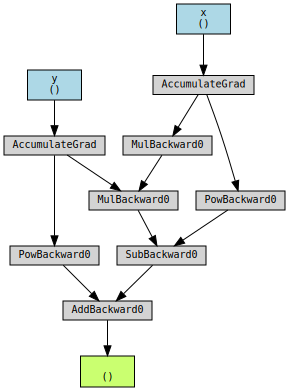

In [15]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

val = x ** 2 - 2 * x * y + y ** 2
val.backward()

print(x.grad, y.grad)

torchviz.make_dot(val, {'x': x, 'y': y})

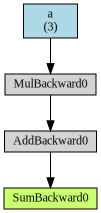

In [8]:
a = torch.tensor([1, 2, 3.], requires_grad=True) 
b = (5 * a + 2).sum()

torchviz.make_dot(b, {'a': a})

# Градиентный спуск

Реализуем наивный градиентный спуск для функции $f(x) = x^2 - 2x + 1$

In [9]:
x = torch.tensor(2., requires_grad=True)
lr = 1e-2

for i in range(500):
    val = x ** 2 - 2 * x + 1
    val.backward()
    
    with torch.no_grad(): 
        x -= lr * x.grad
    
    x.grad.zero_()

print(x)

tensor(1.0000, requires_grad=True)


# Линейная регрессия

### Сгенерируем тренировочное, тестовое и валидационное множества

In [10]:
class DataGen:
    def __init__(self,  
            n=3, 
            a=[1.2, 3.0, -1.5],
            b=[25]):                
        
        self.n = 3        
        self.a = np.array(a).reshape((1, -1))
        self.b = np.array(b).reshape((1, -1))
        
    def gen_Xy(self, count=50):
        a, b = self.a, self.b
        
        noise = np.random.normal(0., 1., size=(count, 1))
        X = np.random.uniform(-30.0, 30.0, size=(count, self.n))
        y = X @ a.T + self.b + noise
        
        return X, y
        
    def gen_Xy_torch(self, count=50, device='cpu'):
        X, y = self.gen_Xy(count)
        return [torch.tensor(t, dtype=torch.float, device=device) for t in (X, y) ]
        

In [11]:
n, l, t, v = 3, 300, 50, 10
dg = DataGen(n=n)

X_train, y_train = dg.gen_Xy_torch(l)
X_test, y_test = dg.gen_Xy_torch(t)
X_val, y_val = dg.gen_Xy_torch(t)

In [12]:
X_train[:10], y_train[:10]

(tensor([[ 14.7940, -27.8577, -17.1852],
         [ 10.8309,  -7.1558,  19.4959],
         [ 12.8625,  25.4021,  15.1339],
         [  4.1456,   8.0469, -28.7858],
         [-13.9301,  20.5040,  28.6081],
         [ 27.6212,  -2.6840,  20.5943],
         [-29.0864, -28.0095, -22.1735],
         [ -2.1245, -23.1596,  16.8079],
         [ 27.8804,   4.4748, -22.0981],
         [ -0.6870,  13.8609, -22.1685]]),
 tensor([[-16.1160],
         [-12.3924],
         [ 95.0541],
         [ 96.0076],
         [ 27.1318],
         [ 21.3712],
         [-60.2942],
         [-71.2829],
         [103.6911],
         [ 98.8805]]))

# Простой градиентый спуск

In [13]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

learnin_rate = 1e-3
max_epochs = 1000

for epoch in tqdm.trange(max_epochs):
    y_pred = torch.mm(X_train, a.T) + b
    mse = ((y_train - y_pred) ** 2).mean()
    
    mse.backward()
    with torch.no_grad():
        a -= learnin_rate * a.grad
        b -= learnin_rate * b.grad
        
    a.grad.zero_()
    b.grad.zero_()

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:00<00:00, 3760.99it/s]

tensor([[ 1.2012,  2.9850, -1.5039]], requires_grad=True)
tensor([[21.7280]], requires_grad=True)


# Встроенные оптимизаторы (SGD) и функция потерь (MSELoss)

In [14]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    y_pred = torch.mm(X_train, a.T) + b
    mse = loss(y_train, y_pred)
    
    mse.backward()

    optimizer.step()
    optimizer.zero_grad()    

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:00<00:00, 3155.84it/s]

tensor([[ 1.2012,  2.9850, -1.5039]], requires_grad=True)
tensor([[21.7226]], requires_grad=True)


# Батчи

In [15]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()

max_epochs = 1000
batch_size = 30
l = len(X_train)
for epoch in tqdm.trange(max_epochs):
    for batch in range((l + batch_size - 1) // batch_size): 
        s, e = (batch * batch_size), min((batch + 1) * batch_size, l)
        X_batch = X_train[s:e]
        
        y_pred = torch.mm(X_batch, a.T) + b
        mse = loss(y_train[s:e], y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:02<00:00, 358.48it/s]

tensor([[ 1.1930,  2.9922, -1.4927]], requires_grad=True)
tensor([[25.1076]], requires_grad=True)


# Батчи через Dataset и Dataloader

In [16]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in data_loader:                
        y_pred = torch.mm(X_batch, a.T) + b
        mse = loss(y_batch, y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(a) 
print(b) 

100%|██████████| 1000/1000 [00:05<00:00, 173.32it/s]

tensor([[ 1.1930,  2.9922, -1.4927]], requires_grad=True)
tensor([[25.1076]], requires_grad=True)


# Расширение nn.Module

In [17]:
class LinearRegression(nn.Module):
    def __init__(self, n=3):
        super().__init__()
        self.linear = nn.Linear(n, 1)
                
    def forward(self, x):        
        return self.linear(x)
    

model = LinearRegression(n)
#model = nn.Sequential(nn.Linear(n, 1))
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in data_loader:   
        model.train()
        y_pred = model(X_batch)
        mse = loss(y_batch, y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(model.state_dict()['linear.weight'])      
print(model.state_dict()['linear.bias'])    

100%|██████████| 1000/1000 [00:06<00:00, 158.69it/s]

tensor([[ 1.1930,  2.9922, -1.4927]])
tensor([25.1076])


# Tensorboard

Запуск в командной строке:

```tensorboard --logdir .```

In [18]:
writer = SummaryWriter()

model = nn.Sequential(nn.Linear(n, 1))
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 100
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in train_loader:   
        model.train()
        y_pred = model(X_batch)
        mse = loss(y_batch, y_pred)

        mse.backward()        

        optimizer.step()
        optimizer.zero_grad()  
        
    if epoch % 3 == 0:
        with torch.no_grad():
            model.eval()
            y_pred = model(X_val)
            mse_val = loss(y_val, y_pred)
            
            stat = { 'mse_validation': mse_val.item(),
                     'b': model.state_dict()['0.bias']    
            }
            writer.add_graph(model, X_val)
            writer.add_scalars('training/stat', stat, epoch)
            torch.save(model, 'checkpoint')
            
writer.close()

print(model.state_dict()['0.weight'])      
print(model.state_dict()['0.bias'])    

100%|██████████| 100/100 [00:01<00:00, 77.78it/s]

tensor([[ 1.1580,  2.9689, -1.5137]])
tensor([21.7453])


# Использование Ignite

In [19]:
import torch.nn.functional as F

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import MeanSquaredError

max_epochs = 100

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=30)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

model = nn.Sequential(nn.Linear(n, 1))
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MeanSquaredError()

trainer = create_supervised_trainer(model, optimizer, F.mse_loss)
evaluator = create_supervised_evaluator(model,  metrics={'mse': loss})

writer = SummaryWriter()
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    mse = metrics['mse']
    writer.add_scalar('training/mse_train', mse, engine.state.epoch)

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    mse = metrics['mse']    
    print(f'Validation Results - Epoch: {engine.state.epoch},  MSE: {mse:.2f}')                  
    writer.add_scalar('training/mse_validation', mse, engine.state.epoch)
        
trainer.run(train_loader, max_epochs=max_epochs)

writer.close()

Validation Results - Epoch: 1,  MSE: 647.15
Validation Results - Epoch: 2,  MSE: 621.33
Validation Results - Epoch: 3,  MSE: 596.65
Validation Results - Epoch: 4,  MSE: 572.93
Validation Results - Epoch: 5,  MSE: 550.16
Validation Results - Epoch: 6,  MSE: 528.29
Validation Results - Epoch: 7,  MSE: 507.28
Validation Results - Epoch: 8,  MSE: 487.10
Validation Results - Epoch: 9,  MSE: 467.73
Validation Results - Epoch: 10,  MSE: 449.12
Validation Results - Epoch: 11,  MSE: 431.24
Validation Results - Epoch: 12,  MSE: 414.08
Validation Results - Epoch: 13,  MSE: 397.59
Validation Results - Epoch: 14,  MSE: 381.76
Validation Results - Epoch: 15,  MSE: 366.55
Validation Results - Epoch: 16,  MSE: 351.95
Validation Results - Epoch: 17,  MSE: 337.93
Validation Results - Epoch: 18,  MSE: 324.46
Validation Results - Epoch: 19,  MSE: 311.53
Validation Results - Epoch: 20,  MSE: 299.10
Validation Results - Epoch: 21,  MSE: 287.18
Validation Results - Epoch: 22,  MSE: 275.72
Validation Results 